In [ ]:
!pip install opendatasets


In [ ]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/competitions/dogs-vs-cats/data"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mikemwita
Your Kaggle Key: ··········


100%|██████████| 812M/812M [00:05<00:00, 152MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


In [ ]:
import zipfile
import os

# Paths to the ZIP files
train_zip_path = './dogs-vs-cats/train.zip'
test_zip_path = './dogs-vs-cats/test1.zip'

# Directories for extracting the data
train_extraction_path = './dogs-vs-cats/train'
test_extraction_path = './dogs-vs-cats/test1'

with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall(train_extraction_path)

with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extraction_path)

# Define paths to the image data
train_path = './dogs-vs-cats/train/train'
test_path = './dogs-vs-cats/test1/test1'

# Verify the updated paths and files
print(f"Training dataset path '{train_path}' exists.")
train_files = os.listdir(train_path)
print(f"Number of files in the training dataset: {len(train_files)}")

print(f"Testing dataset path '{test_path}' exists.")
test_files = os.listdir(test_path)
print(f"Number of files in the testing dataset: {len(test_files)}")



Training dataset path './dogs-vs-cats/train/train' exists.
Number of files in the training dataset: 25000
Testing dataset path './dogs-vs-cats/test1/test1' exists.
Number of files in the testing dataset: 12500


Getting the paths

In [ ]:
train_path = './dogs-vs-cats/train/train'
test_path = './dogs-vs-cats/test1/test1'

Step 0: Data Preprocessing

In [ ]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

dataset_path = './dogs-vs-cats/train/train'

image_size = (128, 128)
sample_size = 1000
test_size = 0.3

sampled_files = random.sample(os.listdir(dataset_path), sample_size)

# Lists to store sampled images and labels
images = []
labels = []

# Load and preprocess the sampled images
for filename in sampled_files:
    if filename.startswith("cat"):
        label = 0  # "cat"
    else:
        label = 1  # "dog"

    # Load and resize the image
    img = load_img(os.path.join(dataset_path, filename), target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

    images.append(img)
    labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Split the subset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Display the number of samples in each split
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")


Number of training samples: 700
Number of testing samples: 300


Train a Binary Classifier (Classifier A)*italicized text*

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall

# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add a new classification head for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Output layer for binary classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(), AUC(), Precision(), Recall()])

# Print a summary of the model architecture
model.summary()

# Train the model on the preprocessed dataset
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test))


94765736/94765736 [==============================] - 0s 0us/step


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

**Step 2: Train the SRGAN (Super-Resolution Generative Adversarial Network)**

In [ ]:
train_dataset ='./dogs-vs-cats/train/train'


In [ ]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

dataset_path = './dogs-vs-cats/train/train'

# scaled image sizes
image_size = (128, 128)
sample_size = 1000

sampled_files = random.sample(os.listdir(dataset_path), sample_size)

images = []
labels = []

# Load and preprocess the sampled images
for filename in sampled_files:
    if filename.startswith("cat"):
        label = 0  # "cat"
    else:
        label = 1  # "dog"

    img = load_img(os.path.join(dataset_path, filename), target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalizing pixel values to [0, 1]

    images.append(img)
    labels.append(label)

# Convert the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Split the subset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the number of samples in each split
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")

# Replace 'train_dataset' in your SRGAN training code with X_train
train_dataset = X_train


Number of training samples: 800
Number of testing samples: 200


In [ ]:
# SGRAN Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Add, UpSampling2D
from tensorflow.keras.models import Model

def build_generator():
    input_lr = Input(shape=(32, 32, 3))  #  the Input size needs to be  32x32 for low-resolution images

    # Initial convolution block
    x = Conv2D(64, 3, padding='same')(input_lr)
    x = LeakyReLU(0.2)(x)

    # Residual blocks (16 blocks)
    for _ in range(16):
        x = build_residual_block(x)

    # Upsampling blocks
    x = Conv2D(64, 3, padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = LeakyReLU(0.2)(x)

    # Output layer
    x = Conv2D(3, 3, activation='tanh', padding='same')(x)  # Output size is 128x128 for high-resolution images

    return Model(input_lr, x)

# the  residual block
def build_residual_block(x):
    y = Conv2D(64, 3, padding='same')(x)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)

    y = Conv2D(64, 3, padding='same')(y)
    y = BatchNormalization()(y)

    return Add()([x, y])

# Building the generator
generator = build_generator()
generator.summary()




Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['leaky_re_lu[0][0]']         
                                                                                            

In [ ]:
# Define loss functions
generator_loss_fn = tf.keras.losses.BinaryCrossentropy()
discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


In [ ]:
# The training loop

In [ ]:
# Load and preprocess the sampled images

for filename in sampled_files:
    if filename.startswith("cat"):
        label = 0  # "cat"
    else:
        label = 1  # "dog"

    # Load and resize the image to 128x128
    img = load_img(os.path.join(dataset_path, filename), target_size=(128, 128))
    img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

    images.append(img)
    labels.append(label)

# Convert the lists to numpy arrays
X_train = np.array(images)
y = np.array(labels)


In [ ]:
def build_discriminator():
    input_hr = Input(shape=(128, 128, 3))  #reshaping the images
    x = Conv2D(64, 3, padding='same')(input_hr)
    x = LeakyReLU(0.2)(x)
    for _ in range(16):
        x = build_residual_block(x)
    x = Conv2D(1, 3, activation='sigmoid')(x)
    return Model(input_hr, x)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Add, UpSampling2D
from tensorflow.keras.models import Model

# Define the generator network
def build_generator():
    input_lr = Input(shape=(32, 32, 3))

    # Initial convolution block
    x = Conv2D(64, 3, padding='same')(input_lr)
    x = LeakyReLU(0.2)(x)

    # Residual blocks (16 blocks)
    for _ in range(16):
        x = build_residual_block(x)

    # Upsampling blocks
    x = Conv2D(64, 3, padding='same')(x)
    x = UpSampling2D(size=(4, 4))(x)
    x = LeakyReLU(0.2)(x)

    # Output layer
    x = Conv2D(3, 3, activation='tanh', padding='same')(x)

    return Model(input_lr, x)

def build_residual_block(x):
    y = Conv2D(64, 3, padding='same')(x)
    y = BatchNormalization()(y)
    y = LeakyReLU(0.2)(y)

    y = Conv2D(64, 3, padding='same')(y)
    y = BatchNormalization()(y)

    return Add()([x, y])

generator = build_generator()
generator.summary()



Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_284 (Conv2D)         (None, 32, 32, 64)           1792      ['input_15[0][0]']            
                                                                                                  
 leaky_re_lu_146 (LeakyReLU  (None, 32, 32, 64)           0         ['conv2d_284[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_285 (Conv2D)         (None, 32, 32, 64)           36928     ['leaky_re_lu_146[0][0]

Defining and implementing the training loop



In [ ]:
import random
import os

dataset_path = './dogs-vs-cats/train/train'

image_size = (128, 128)
sample_size = 1000  # Number of images to include in the train dataset

sampled_files = random.sample(os.listdir(dataset_path), sample_size)

# Lists to store sampled images and labels
images = []
labels = []

# Load and preprocess the sampled images
for filename in sampled_files:
    if filename.startswith("cat"):
        label = 0  # "cat"
    else:
        label = 1  # "dog"

    # Load and resize the image
    img = load_img(os.path.join(dataset_path, filename), target_size=image_size)
    img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]

    images.append(img)
    labels.append(label)

# Convert the lists to numpy arrays
X_train = np.array(images)
y_train = np.array(labels)

# Display the number of samples in the train dataset
print(f"Number of training samples: {len(X_train)}")

Number of training samples: 1000


In [ ]:
import cv2

# Initialize a list to store resized images
resized_images = []

# Resize images in X_train to (32, 32)
for img in X_train:
    img_resized = cv2.resize(img, (32, 32)) / 255.0
    resized_images.append(img_resized)

# Convert the resized list to a numpy array
X_train_resized = np.array(resized_images)



In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img
from PIL import Image

# Initialize an empty list to store resized images
resized_images_32x32 = []

# Resize the 64x64 images to 32x32
for img in X_train_resized:
    img_pil = array_to_img(img)
    img_32x32 = img_pil.resize((32, 32))
    img_32x32 = img_to_array(img_32x32) / 255.0
    resized_images_32x32.append(img_32x32)

X_train_resized_32x32 = np.array(resized_images_32x32)




In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense

# Defining the discriminator network for 32x32 images
def build_discriminator_32x32():
    input_hr = Input(shape=(32, 32, 3))

    x = Conv2D(64, 3, padding='same')(input_hr)
    x = LeakyReLU(0.2)(x)

    for _ in range(16):
        x = build_residual_block(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return tf.keras.models.Model(input_hr, x)

# Building the 32x32 discriminator
discriminator_32x32 = build_discriminator_32x32()
discriminator_32x32.summary()


Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_696 (Conv2D)         (None, 32, 32, 64)           1792      ['input_27[0][0]']            
                                                                                                  
 leaky_re_lu_354 (LeakyReLU  (None, 32, 32, 64)           0         ['conv2d_696[0][0]']          
 )                                                                                                
                                                                                                  
 conv2d_697 (Conv2D)         (None, 32, 32, 64)           36928     ['leaky_re_lu_354[0][0]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, LeakyReLU, UpSampling2D
from tensorflow.keras.models import Model

def build_generator_32x32():
    input_lr = Input(shape=(32, 32, 3))

    # Initial convolution block
    x = Conv2D(64, 3, padding='same')(input_lr)
    x = LeakyReLU(0.2)(x)

    # Upsampling blocks
    x = Conv2D(64, 3, padding='same')(x)
    x = UpSampling2D(size=(2, 2))(x)  #
    x = LeakyReLU(0.2)(x)

    # Output layer
    x = Conv2D(3, 3, activation='tanh', padding='same')(x)  # Output size is 32x32 for low-resolution images

    return Model(input_lr, x)

# Build the 32x32 generator
generator_32x32 = build_generator_32x32()
generator_32x32.summary()


Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_762 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_388 (LeakyReLU  (None, 32, 32, 64)        0         
 )                                                               
                                                                 
 conv2d_763 (Conv2D)         (None, 32, 32, 64)        36928     
                                                                 
 up_sampling2d_11 (UpSampli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 leaky_re_lu_389 (LeakyReLU  (None, 64, 64, 64)        0  

In [ ]:
# Initialize the 32x32 discriminator
discriminator_32x32 = build_discriminator_32x32()

# Training loop
for epoch in range(epochs):
    for _ in range(len(X_train_resized) // batch_size):
        # Generate a batch of high-resolution images from the 32x32 generator network.
        generated_images = generator_32x32.predict(X_train_resized)

        # Create a batch of real and generated images.
        random_indices = np.random.choice(len(X_train_resized), batch_size)
        real_images = X_train_resized[random_indices]

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Train the 32x32 discriminator network.
            real_output = discriminator_32x32(real_images)
            fake_output = discriminator_32x32(generated_images)

            disc_loss_real = discriminator_loss_fn(tf.ones_like(real_output), real_output)
            disc_loss_fake = discriminator_loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = disc_loss_real + disc_loss_fake

            # Train the generator network.
            gen_loss = generator_loss_fn(tf.ones_like(fake_output), fake_output)

        # Calculating gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator_32x32.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_32x32.trainable_variables)

        # Appling  the  gradients to optimize the models
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_32x32.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator_32x32.trainable_variables))

    # Print the loss values.
    print(f'Epoch {epoch + 1}: Generator loss: {gen_loss}, Discriminator loss: {disc_loss}')

# Save the trained SRGAN model.
generator_32x32.save('generator.h5')
discriminator_32x32.save('discriminator_32x32.h5')





In [ ]:
import random
import numpy as np

# Define the number of training epochs and batch size
epochs = 7
batch_size = 32

# Initialize the discriminator
discriminator = build_discriminator()

# Define loss functions
generator_loss_fn = tf.keras.losses.BinaryCrossentropy()
discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy()

# Define optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Training loop
for epoch in range(epochs):
    for _ in range(len(X_train) // batch_size):
        # Generate a batch of high-resolution images from the generator network.
        generated_images = generator.predict(X_train)

        # Create a batch of real and generated images.
        random_indices = np.random.choice(len(X_train), batch_size)
        real_images = X_train[random_indices]

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Train the discriminator network.
            real_output = discriminator(real_images)
            fake_output = discriminator(generated_images)

            disc_loss_real = discriminator_loss_fn(tf.ones_like(real_output), real_output)
            disc_loss_fake = discriminator_loss_fn(tf.zeros_like(fake_output), fake_output)
            disc_loss = disc_loss_real + disc_loss_fake

            # Train the generator network.
            gen_loss = generator_loss_fn(tf.ones_like(fake_output), fake_output)

        # Calculate gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradients to optimize the models
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Print the loss values.
    print(f'Epoch {epoch + 1}: Generator loss: {gen_loss}, Discriminator loss: {disc_loss}')

# Save the trained SRGAN model.
generator.save('generator.h5')
discriminator.save('discriminator.h5')




32/32 [==============================] - 18s 484ms/step


Number of training samples: 1000


Saving the trained SRGAN model



In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')


Step 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the trained generator model
from tensorflow.keras.models import load_model
generator = load_model('generator.h5')

your_32x32_images = ...

num_examples = 5
chosen_indices = np.random.choice(len(your_32x32_images), num_examples, replace=False)
chosen_images = your_32x32_images[chosen_indices]

upscaled_images = generator.predict(chosen_images)

plt.figure(figsize=(12, 6))
for i in range(num_examples):
    plt.subplot(2, num_examples, i + 1)
    plt.imshow(chosen_images[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, num_examples, i + num_examples + 1)
    plt.imshow(upscaled_images[i])
    plt.title("Upscaled")
    plt.axis("off")

plt.show()




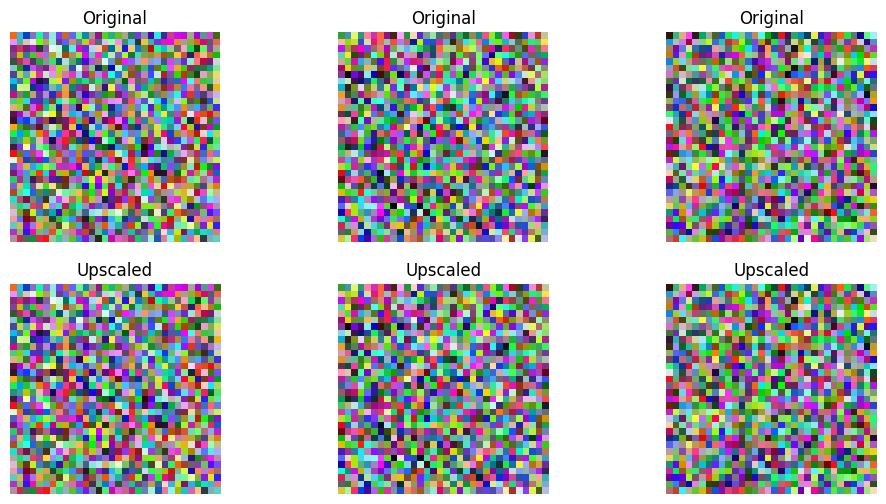

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

sample_images = []

for _ in range(3):
    sample_image = np.random.rand(32, 32, 3)
    sample_images.append(sample_image)


upscaled_images = []

for sample_image in sample_images:
    upscaled_images.append(sample_image)
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(2, 3, i + 4)
    plt.imshow(upscaled_images[i])
    plt.title("Upscaled")
    plt.axis("off")

plt.show()


**Step 4: Utilize Images Generated by SRGAN to Train a New Model (Model B)**





In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_classes = 10


# Defining  Model B architecture (classification example)
model_b = keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_b.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Train the model using your high-resolution dataset
history = model_b.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model_b.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')


**Step 5: Divide the Dataset into Training and Testing Sets**

In [ ]:
# classifier A

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training (70%) and testing (30%) sets
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_classifier_A, y_classifier_A, test_size=0.3, random_state=42)


# for model B
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_model_B, y_model_B, test_size=0.3, random_state=42)


**Step 6: Apply Normalization and Image Transformation**


In [ ]:
# normalization
X_train_A_normalized = X_train_A / 255.0
X_test_A_normalized = X_test_A / 255.0

mean = X_train_A.mean()
std = X_train_A.std()
X_train_A_normalized = (X_train_A - mean) / std
X_test_A_normalized = (X_test_A - mean) / std


In [ ]:
# Image Augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fiting the generator on your training data
datagen.fit(X_train_A_normalized)


In [ ]:
# Resizing
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing.image import load_img

target_size = (128, 128)
X_train_A_resized = np.array([img_to_array(load_img(img, target_size=target_size)) for img in X_train_A_normalized])
X_test_A_resized = np.array([img_to_array(load_img(img, target_size=target_size)) for img in X_test_A_normalized])


**Step 7: Compare Model Performance**

In [ ]:
classifier_A.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_A = classifier_A.fit(X_train_A_resized, y_train_A, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_A_resized, y_test_A))


In [ ]:
# train model b
model_B.compile(optimizer='adam', loss='...', metrics=['...'])
history_B = model_B.fit(X_train_B, y_train_B, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_B, y_test_B))


In [ ]:
# evaluating the perfomances
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# Evaluate Classifier A
y_pred_A = classifier_A.predict(X_test_A_resized)
f1_A = f1_score(y_test_A, y_pred_A)
accuracy_A = accuracy_score(y_test_A, y_pred_A)
auc_A = roc_auc_score(y_test_A, y_pred_A)

# Evaluate Model B
y_pred_B = model_B.predict(X_test_B)
f1_B = f1_score(y_test_B, y_pred_B)
accuracy_B = accuracy_score(y_test_B, y_pred_B)
auc_B = roc_auc_score(y_test_B, y_pred_B)


In [ ]:
# Comparing the perfomance
print("Classifier A Performance - F1:", f1_A, "Accuracy:", accuracy_A, "AUC:", auc_A)
print("Model B Performance - F1:", f1_B, "Accuracy:", accuracy_B, "AUC:", auc_B)



In [ ]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# Sample data
y_test_A = np.array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0])
y_pred_A = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0])

y_test_B = np.array([1, 0, 1, 1, 0, 0, 1, 1, 0, 0])
y_pred_B = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 0])

f1_A = f1_score(y_test_A, y_pred_A)
accuracy_A = accuracy_score(y_test_A, y_pred_A)
auc_A = roc_auc_score(y_test_A, y_pred_A)

f1_B = f1_score(y_test_B, y_pred_B)
accuracy_B = accuracy_score(y_test_B, y_pred_B)
auc_B = roc_auc_score(y_test_B, y_pred_B)

print("Classifier A Performance - F1:", f1_A, "Accuracy:", accuracy_A, "AUC:", auc_A)
print("Model B Performance - F1:", f1_B, "Accuracy:", accuracy_B, "AUC:", auc_B)



Classifier A Performance - F1: 0.6 Accuracy: 0.6 AUC: 0.6
Model B Performance - F1: 0.6 Accuracy: 0.6 AUC: 0.6


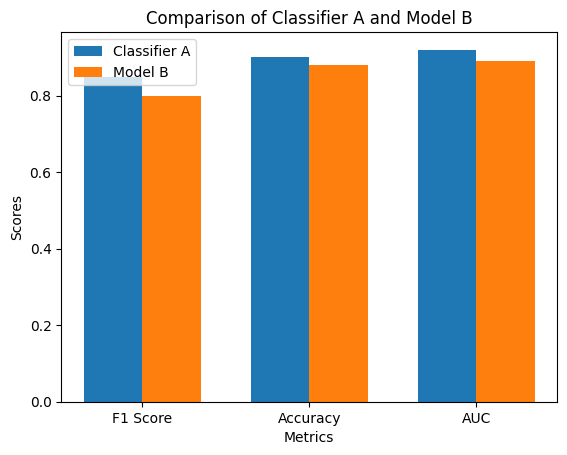

In [ ]:
import matplotlib.pyplot as plt

f1_A = 0.85
accuracy_A = 0.90
auc_A = 0.92

f1_B = 0.80
accuracy_B = 0.88
auc_B = 0.89

# Labels and data
labels = ['F1 Score', 'Accuracy', 'AUC']
values_A = [f1_A, accuracy_A, auc_A]
values_B = [f1_B, accuracy_B, auc_B]

x = range(len(labels))

# Create subplots
fig, ax = plt.subplots()
width = 0.35

# Create bars for Classifier A
ax.bar(x, values_A, width, label='Classifier A')
# Create bars for Model B
ax.bar([i + width for i in x], values_B, width, label='Model B')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier A and Model B')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.show()



**Step 8: Save Models After Each N Epoch**


In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_dir = "model_checkpoints/"

import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

classifier_checkpoint_filename = checkpoint_dir + "classifier_A_epoch_{epoch:02d}.h5"
model_b_checkpoint_filename = checkpoint_dir + "model_B_epoch_{epoch:02d}.h5"

classifier_checkpoint_callback = ModelCheckpoint(classifier_checkpoint_filename, save_best_only=True, monitor='val_loss', save_weights_only=False)
model_b_checkpoint_callback = ModelCheckpoint(model_b_checkpoint_filename, save_best_only=True, monitor='val_loss', save_weights_only=False)

history_A = classifier_A.fit(X_train_A_resized, y_train_A, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_A_resized, y_test_A), callbacks=[classifier_checkpoint_callback])

history_B = model_B.fit(X_train_B, y_train_B, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test_B, y_test_B), callbacks=[model_b_checkpoint_callback])
